In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import StepLR
import numpy as np
from datetime import datetime
import pandas as pd
import random 
from torchvision.datasets import ImageFolder
import re
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from PIL import Image
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import roc_auc_score
from skimage.io import imread, imsave
import skimage
from PIL import ImageFile
from PIL import Image

torch.cuda.empty_cache()

In [ ]:
def metric(predlist,tarlist,scorelist):
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    TP = ((predlist == 1) & (tarlist == 1)).sum()
    TN = ((predlist == 0) & (tarlist == 0)).sum()
    FN = ((predlist == 0) & (tarlist == 1)).sum()
    FP = ((predlist == 1) & (tarlist == 0)).sum()
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    AUC = roc_auc_score(tarlist,scorelist)
    return TP,TN,FN,FP,p,r,F1,acc,AUC

In [ ]:
normalize = transforms.Normalize(mean=[0.45271412, 0.45271412, 0.45271412],
                                     std=[0.33165374, 0.33165374, 0.33165374])
train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop((224),scale=(0.5,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    normalize
])

val_transformer = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    normalize
])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
import os
#load dataset 
os.chdir('/content/drive/Shareddrives/EC523_Project/COVID-CT-master/')

Mounted at /content/drive


In [ ]:
batchsize=4
def read_txt(txt_path):
    with open(txt_path) as f:
        lines = f.readlines()
    txt_data = [line.strip() for line in lines]
    return txt_data

class CovidCTDataset(Dataset):
    def __init__(self, root_dir, txt_COVID, txt_NonCOVID, transform=None):
        """
        Args:
            txt_path (string): Path to the txt file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        File structure:
        - root_dir
            - CT_COVID
                - img1.png
                - img2.png
                - ......
            - CT_NonCOVID
                - img1.png
                - img2.png
                - ......
        """
        self.root_dir = root_dir
        self.txt_path = [txt_COVID,txt_NonCOVID]
        self.classes = ['CT_COVID', 'CT_NonCOVID']
        self.num_cls = len(self.classes)
        self.img_list = []
        for c in range(self.num_cls):
            cls_list = [[os.path.join(self.root_dir,self.classes[c],item), c] for item in read_txt(self.txt_path[c])]
            self.img_list += cls_list
        self.transform = transform

    def __len__(self):
        return len(self.img_list)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_path = self.img_list[idx][0]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)
        sample = {'img': image,
                  'label': int(self.img_list[idx][1])}
        return sample



    
if __name__ == '__main__':


    trainset = CovidCTDataset(root_dir='./Images-processed',
                              txt_COVID='./Data-split/COVID/trainCT_COVID.txt',
                              txt_NonCOVID='./Data-split/NonCOVID/trainCT_NonCOVID.txt',
                              transform= train_transformer)
    valset = CovidCTDataset(root_dir='./Images-processed',
                              txt_COVID='./Data-split/COVID/valCT_COVID.txt',
                              txt_NonCOVID='./Data-split/NonCOVID/valCT_NonCOVID.txt',
                              transform= train_transformer)
    
    testset = CovidCTDataset(root_dir='./Images-processed',
                              txt_COVID='./Data-split/COVID/testCT_COVID.txt',
                              txt_NonCOVID='./Data-split/NonCOVID/testCT_NonCOVID.txt',
                              transform= train_transformer)
    print(trainset.__len__())
    print(valset.__len__())
    print(testset.__len__())

    train_loader = DataLoader(trainset, batch_size=batchsize, drop_last=False, shuffle=True)
    val_loader = DataLoader(valset, batch_size=batchsize, drop_last=False, shuffle=False)
    test_loader = DataLoader(testset, batch_size=batchsize, drop_last=False, shuffle=False)
    

425
118
203


# 新段落

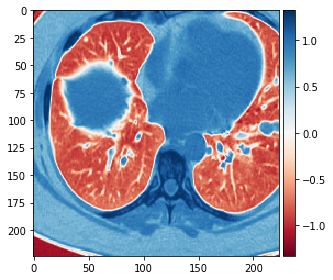

In [ ]:
for batch_index, batch_samples in enumerate(train_loader):      
        data, target = batch_samples['img'], batch_samples['label']
        break 
skimage.io.imshow(data[0,1,:,:].numpy())

In [ ]:
device = 'cuda'

def train(optimizer, epoch):
    
    model.train()
    
    train_loss = 0
    train_correct = 0
    
    for batch_index, batch_samples in enumerate(train_loader):
  
        data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
        
        optimizer.zero_grad()
        output = model(data)
        criteria = nn.CrossEntropyLoss()
        loss = criteria(output, target.long())
        train_loss += loss
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        pred = output.argmax(dim=1, keepdim=True)
        train_correct += pred.eq(target.long().view_as(pred)).sum().item()
    
        # Display progress and write to tensorboard
        if batch_index % bs == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tTrain Loss: {:.6f}'.format(
                epoch, batch_index, len(train_loader),
                100.0 * batch_index / len(train_loader), loss.item()/ bs))
  

In [ ]:
def val(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    
    
    criteria = nn.CrossEntropyLoss()
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        for batch_index, batch_samples in enumerate(val_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            output = model(data)
            
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
           
    return targetlist, scorelist, predlist
    

In [ ]:
def test(epoch):
    
    model.eval()
    test_loss = 0
    correct = 0
    results = []
    
    criteria = nn.CrossEntropyLoss()
    # Don't update model
    with torch.no_grad():
        tpr_list = []
        fpr_list = []
        
        predlist=[]
        scorelist=[]
        targetlist=[]
        for batch_index, batch_samples in enumerate(test_loader):
            data, target = batch_samples['img'].to(device), batch_samples['label'].to(device)
            output = model(data)
            test_loss += criteria(output, target.long())
            score = F.softmax(output, dim=1)
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.long().view_as(pred)).sum().item()
            targetcpu=target.long().cpu().numpy()
            predlist=np.append(predlist, pred.cpu().numpy())
            scorelist=np.append(scorelist, score.cpu().numpy()[:,1])
            targetlist=np.append(targetlist,targetcpu)
    return targetlist, scorelist, predlist
    

In [ ]:
#load densenet169 pretrained model

import torchvision.models as models

model = models.densenet169(pretrained=True).cuda()
pretrained_net = torch.load('/content/drive/Shareddrives/EC523_Project/COVID-CT-master/baseline_methods/Self-Trans/Self-Trans.pt')

model.load_state_dict(pretrained_net)


<All keys matched successfully>

In [ ]:
#network info
child_counter = 0
for child in model.children():
    print(" child", child_counter, "is -")
    print(child)
    child_counter += 1

 child 0 is -
Sequential(
  (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu0): ReLU(inplace=True)
  (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (denseblock1): _DenseBlock(
    (denselayer1): _DenseLayer(
      (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu2): ReLU(inplace=True)
      (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (denselayer2): _DenseLayer(
      (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (conv1): Conv

In [ ]:
def metric(predlist,tarlist)
    TP = 0
    TN = 0
    FN = 0
    FP = 0
    TP = ((vote_pred == 1) & (targetlist == 1)).sum()
    TN = ((vote_pred == 0) & (targetlist == 0)).sum()
    FN = ((vote_pred == 0) & (targetlist == 1)).sum()
    FP = ((vote_pred == 1) & (targetlist == 0)).sum()
    p = TP / (TP + FP)
    r = TP / (TP + FN)
    F1 = 2 * r * p / (r + p)
    acc = (TP + TN) / (TP + TN + FP + FN)
    return TP,TN,FN,FP,p,r,F1,acc

In [ ]:
# train
bs =batchsize
votenum = 10


r_list = []
p_list = []
acc_list = []
AUC_list = []
vote_pred = np.zeros(valset.__len__())
vote_score = np.zeros(valset.__len__())

optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)                                            
scheduler = StepLR(optimizer, step_size=1)

total_epoch = 300
for epoch in range(1, total_epoch+1):
    train(optimizer, epoch)
    
    targetlist, scorelist, predlist = val(epoch)
    print('target',targetlist)
    print('score',scorelist)
    print('predict',predlist)
    vote_pred = vote_pred + predlist 
    vote_score = vote_score + scorelist 

    if epoch % votenum == 0:
        
        # major vote
        vote_pred[vote_pred <= (votenum/2)] = 0
        vote_pred[vote_pred > (votenum/2)] = 1
        vote_score = vote_score/votenum
        
        print('vote_pred', vote_pred)
        print('targetlist', targetlist)
        
        TP,TN,FN,FP,p,r,F1,acc,AUC = metric(vote_pred,targetlist,vote_score)
        
        print('TP=',TP,'TN=',TN,'FN=',FN,'FP=',FP)
        print('TP+FP',TP+FP)     
        print('precision',p)     
        print('recall',r)
        print('F1',F1)
        print('acc',acc)
        print('AUC', AUC)
        

        torch.save(model.state_dict(), "/content/drive/Shareddrives/EC523_Project/COVID-CT-master/baseline_methods/Self-Trans/model/model_without_pretrain/densenet_epoch{}".format(epoch))  
        
        vote_pred = np.zeros(valset.__len__())
        vote_score = np.zeros(valset.__len__())
        print('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f},\
              average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(epoch, r, p, F1, acc, AUC))

        f = open('/content/drive/Shareddrives/EC523_Project/COVID-CT-master/baseline_methods/Self-Trans/model/model_without_pretrain/densenet_performance.txt'.format(modelname,alpha_name), 'a+')
        f.write('\n epoch{}, recall: {:.4f}, precision: {:.4f}, F1: {:.4f}, accuracy: {:.4f}, AUC: {:.4f}'.format(epoch, r, p, F1, acc, AUC))
        f.close()



Train Epoch: 1 [0/107 (0%)]	Train Loss: 2.111317
Train Epoch: 1 [4/107 (4%)]	Train Loss: 1.931460
Train Epoch: 1 [8/107 (7%)]	Train Loss: 1.807946
Train Epoch: 1 [12/107 (11%)]	Train Loss: 1.590160
Train Epoch: 1 [16/107 (15%)]	Train Loss: 1.631512
Train Epoch: 1 [20/107 (19%)]	Train Loss: 1.217755
Train Epoch: 1 [24/107 (22%)]	Train Loss: 1.293069
Train Epoch: 1 [28/107 (26%)]	Train Loss: 0.770824
Train Epoch: 1 [32/107 (30%)]	Train Loss: 1.374873
Train Epoch: 1 [36/107 (34%)]	Train Loss: 0.464583
Train Epoch: 1 [40/107 (37%)]	Train Loss: 1.452163
Train Epoch: 1 [44/107 (41%)]	Train Loss: 0.363899
Train Epoch: 1 [48/107 (45%)]	Train Loss: 0.648300
Train Epoch: 1 [52/107 (49%)]	Train Loss: 0.148125
Train Epoch: 1 [56/107 (52%)]	Train Loss: 0.183063
Train Epoch: 1 [60/107 (56%)]	Train Loss: 0.527291
Train Epoch: 1 [64/107 (60%)]	Train Loss: 0.609839
Train Epoch: 1 [68/107 (64%)]	Train Loss: 0.104856
Train Epoch: 1 [72/107 (67%)]	Train Loss: 0.132701
Train Epoch: 1 [76/107 (71%)]	Train L

KeyboardInterrupt: ignored

In [ ]:
# test
import warnings
warnings.filterwarnings('ignore')

for i in range(30):
  epoch = i*10+10
  model = models.densenet169(pretrained=True).cuda()
  pretrained_net = torch.load('/content/drive/Shareddrives/EC523_Project/COVID-CT-master/baseline_methods/Self-Trans/model/model_trained/densenet_epoch{}'.format(epoch))
  model.load_state_dict(pretrained_net)

  targetlist, scorelist, predlist = test(1)
  TP,TN,FN,FP,p,r,F1,acc,AUC = metric(predlist,targetlist,scorelist)


  f = open('/content/drive/Shareddrives/EC523_Project/COVID-CT-master/baseline_methods/Self-Trans/model/model_trained/densenet_test_performance.txt'.format(modelname,alpha_name), 'a+')
  f.write('\n The epoch is {}, average recall: {:.4f}, average precision: {:.4f}, average F1: {:.4f}, average accuracy: {:.4f}, average AUC: {:.4f}'.format(epoch, r, p, F1, acc, AUC))
  f.close()